# First Steps Toward Inference

In this document, we are taking our first steps toward inferring the maximum likelihood moderl parameters. First, we'll generate some fake data and let it evolve for one time-step under some set model parameters. We then compute the likelihood function over a range of potential parameters to see if we can find the original ones. In this simple demo we just show a 2-dimensional grid search over each pair of coupled parameters. 

In this version we use Ema's original model formulation. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from itertools import product
from urban_growth import simulator 
from urban_growth import estimator 
import copy

%matplotlib inline

# Generate the Data

In [2]:
# Params

## Initial Configuration
L = 200
rho = .44
blur = 2

## Rural/Urban Size Threshold
T = 50

## Dynamical Parameters, not assuming that these are good ones. 
truncation = 20

gamma_r = 2.0
gamma_u = 3.0
alpha_r = 1.5
alpha_u = 2.25

pars = {'gamma_r' : gamma_r,     # rural settlement more diffuse than urban
        'gamma_u' : gamma_u,      
        'alpha_r' : alpha_r,       
        'alpha_u' : alpha_u,
        'truncation' : truncation}


geo = np.ones((L, L))

for i in np.arange(0, L):
    geo[:,i] = 1.0*i / L 

In [3]:
m = simulator.simulator(geo = geo)
m.set_M0(L = L, density = rho, blur = blur)

density_pars = {'thresh'     : T,
                'pars'       : copy.deepcopy(pars),
                'model'      : estimator.model_0,
                'use_geo'    : True,
                'truncation' : truncation, 
                'stage'      : 'initial'}

densities = m.density(**density_pars)

# densities = m.density(T, pars, 
#                       use_geo = True, 
#                       model = model_1,
#                       stage = 'initial', 
#                       truncation = truncation)

prob = densities[0] + densities[1]


dynamics_pars = {'thresh'     : T,
                'pars'       : pars,
                'model'      : estimator.model_0,
                'use_geo'    : True,
                'truncation' : truncation}

M = m.dynamics(n_iters = 1, **dynamics_pars)
M1 = M.copy()
M1[np.isfinite(M1)] = 1
M1[np.isnan(M1)] = 0

urban_growth/model.py:39: RuntimeWarning: invalid value encountered in divide
  return p_r ** 2 / denom, p_u ** 2 / denom
urban_growth/simulator.py:17: RuntimeWarning: invalid value encountered in less
  new_mat = (rands < prob) * 1


Step 1 completed


## Visualize the data


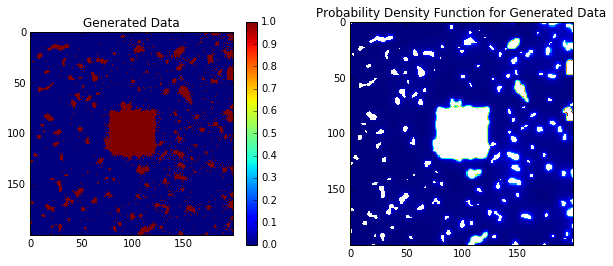

In [4]:
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(121)
im = ax1.imshow(M1, interpolation = 'nearest')
plt.title('Generated Data')
plt.colorbar(im)

ax2 = fig.add_subplot(122)
ax2.imshow(prob, interpolation = 'nearest')
plt.title('Probability Density Function for Generated Data')

In [5]:
e = estimator.estimator(geo = geo)
e.set_M0(M0 = m.get_M0())

# Grid Search

Now we'll evaluate the model likelihood on a range of values of the parameters $\alpha_r$, $\alpha_u$, $\gamma_r$, $\gamma_u$. 

In [ ]:
def grid_search_plot(ax, par_1, par_2, coords_1, coords_2):
    searcher = grid_searcher(par_1, par_2)
    M = do_search(searcher, coords_1,coords_2)
    show_likelihood(M, par_1, par_2, ax, coords_1, coords_2)

def grid_searcher(par_1, par_2):
    def test_likelihood(v_1, v_2):
        internal_pars = copy.deepcopy(density_pars)
        internal_pars['pars'].update({par_1 : v_1, 
                                      par_2 : v_2})
        l1 = e.log_likelihood(M1, normalized = True, **internal_pars)
        return l1
    return test_likelihood

def do_search(searcher, ax1, ax2):
    coords = product(ax1, ax2)
    test = np.array([searcher(coord[0], coord[1]) for coord in coords])
    lls = test.reshape(len(ax1), len(ax2))
    return lls

def show_likelihood(M, par_1, par_2, ax, coords_1, coords_2):
    im = ax.imshow(M, 
           interpolation = 'nearest',
           cmap = 'magma')
    plt.colorbar(im)
    
    ax.set(xlabel = r'$\{}$'.format(par_2),
           ylabel =  r'$\{}$'.format(par_1),
           xlim = (coords_1.min(), coords_1.max()), 
           ylim = (coords_2.min(), coords_2.max()))
    
    ticks = plt.xticks(range(len(coords_1)), coords_1, rotation='vertical')
    ticks = plt.yticks(range(len(coords_2)), coords_2, rotation='horizontal')
    
    true_1 = np.where(coords_1 == pars[par_1])[0][0]
    true_2 = np.where(coords_2 == pars[par_2])[0][0]

    max_ix = np.unravel_index(M.argmax(), M.shape)

    ax.scatter(true_2, true_1, c = 'white', s = 100)
    ax.scatter(max_ix[1], max_ix[0], c = 'black', s = 10)

In [ ]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
grid_search_plot(ax1, 
                 'gamma_r', 
                 'gamma_u', 
                 coords_1 = np.linspace(1, 4, 13), 
                 coords_2 = np.linspace(1, 4, 13))

ax2 = fig.add_subplot(222)
grid_search_plot(ax2, 
                 'gamma_r', 
                 'alpha_r', 
                 coords_1 = np.linspace(1, 4, 13), 
                 coords_2 = np.linspace(1, 4, 13))

ax3 = fig.add_subplot(223)
grid_search_plot(ax3, 
                 'alpha_u', 
                 'gamma_u', 
                 coords_1 = np.linspace(1, 4, 13), 
                 coords_2 = np.linspace(1, 4, 13))

ax4 = fig.add_subplot(224)
grid_search_plot(ax4, 
                 'alpha_u', 
                 'alpha_r', 
                 coords_1 = np.linspace(1, 4, 13), 
                 coords_2 = np.linspace(1, 4, 13))

urban_growth/estimator.py:22: RuntimeWarning: divide by zero encountered in log
  ll = np.nansum(X * np.log(prob) + (1 - X) * np.log(1 - prob))
urban_growth/estimator.py:22: RuntimeWarning: invalid value encountered in multiply
  ll = np.nansum(X * np.log(prob) + (1 - X) * np.log(1 - prob))
urban_growth/estimator.py:22: RuntimeWarning: invalid value encountered in log
  ll = np.nansum(X * np.log(prob) + (1 - X) * np.log(1 - prob))
